In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [2]:
df1 = pd.read_excel('/content/Demand Forecast Analysis/ProductA.xlsx')
df2 = pd.read_excel('/content/Demand Forecast Analysis/ProductA_fb_impressions.xlsx')
df3 = pd.read_excel('/content/Demand Forecast Analysis/ProductA_google_clicks.xlsx')

merge_data = pd.merge(df1, df2, on='Day Index', how='left')
merge_data = pd.merge(merge_data, df3, on='Day Index', how='left')

merge_data.to_csv('merged_data.xlsx', index=False)

In [3]:
merge_data['Day Index'] = pd.to_datetime(merge_data['Day Index'])
merge_data

min_date = merge_data['Day Index'].min()
max_date = merge_data['Day Index'].max()

duration = min_date - max_date
duration

Timedelta('-211 days +00:00:00')

In [4]:
merge_data['new_quantity'] = merge_data['Quantity'].apply(lambda x: x if x > 34 else 0)

# Ensure there are no empty cells in 'new_quantity'
merge_data['new_quantity'].fillna(0, inplace=True)

merge_data.head()

,Day Index,Quantity,Impressions,Clicks,new_quantity
0,2021-12-01,14,620,445,0
1,2021-12-02,10,890,433,0
2,2021-12-03,13,851,424,0
3,2021-12-04,22,881,427,0
4,2021-12-05,33,678,451,0


In [5]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Day Index     212 non-null    datetime64[ns]
 1   Quantity      212 non-null    int64         
 2   Impressions   212 non-null    int64         
 3   Clicks        212 non-null    int64         
 4   new_quantity  212 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 8.4 KB


In [6]:
merge_data.isnull().sum()

Day Index       0
Quantity        0
Impressions     0
Clicks          0
new_quantity    0
dtype: int64

# Outlier Detection

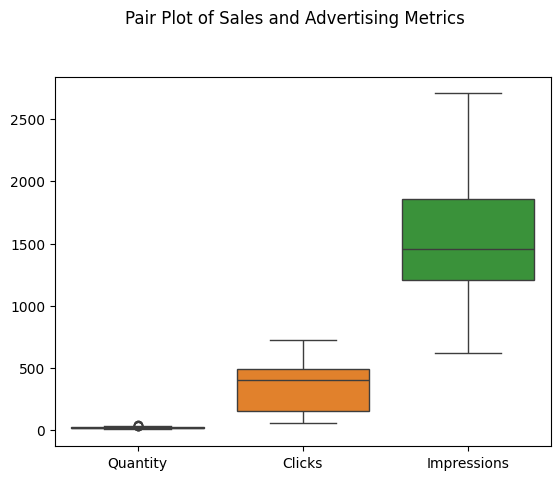

In [7]:


# Pair plot to visualize relationships and distributions
sns.boxplot(merge_data[['Quantity', 'Clicks', 'Impressions']])
plt.suptitle('Pair Plot of Sales and Advertising Metrics', y=1.02)
plt.show()



   Day Index    Quantity  new_quantity  Impressions  Clicks
0 2021-01-01  109.524750    109.524750          655      63
1 2021-01-02  119.963391    119.963391          313      38
2 2021-01-03  108.139154    108.139154          220      80
3 2021-01-04   69.796369     69.796369          233      21
4 2021-01-05   99.813059     99.813059          473      81


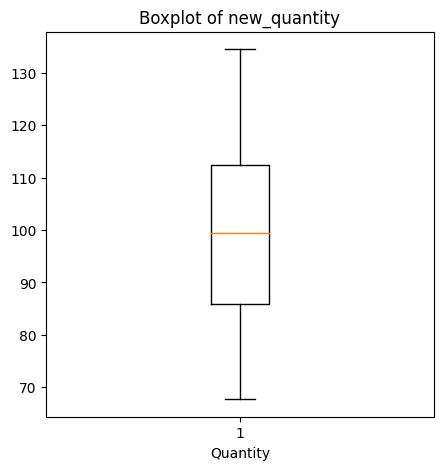

In [8]:


def cap_outliers(df, column, lower_percentile=0.05, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    capped_column = df[column].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)
    return capped_column

# Example usage:
# Assuming merged_df is your DataFrame
date_range = pd.date_range(start='2021-01-01', end='2023-01-01', freq='D')

# Ensure the length of the data arrays matches the length of the date range
data_length = len(date_range)

# Create the DataFrame with the corrected lengths
merged_df = pd.DataFrame({
    'Day Index': date_range,
    'Quantity': np.random.normal(100, 20, data_length),  # Example data for Quantity
    'Impressions': np.random.randint(100, 1000, data_length),  # Example data for Impressions
    'Clicks': np.random.randint(10, 100, data_length)  # Example data for Clicks
})

# Impute outliers in 'Quantity' column
merged_df['new_quantity'] = cap_outliers(merged_df, 'Quantity', lower_percentile=0.05, upper_percentile=0.97)

# Display the first few rows to verify
print(merged_df[['Day Index', 'Quantity', 'new_quantity', 'Impressions', 'Clicks']].head())

# Plot boxplot for 'quantity1'
plt.figure(figsize=(5, 5))
plt.boxplot(merged_df['new_quantity'])
plt.title('Boxplot of new_quantity')
plt.xlabel('Quantity')
plt.show()

# Feature Engineering

In [9]:


# Sample data (replace with your actual DataFrame)
# merge_data = pd.read_csv('your_data.csv')

# Convert 'Day Index' to datetime if it's not already
if merge_data['Day Index'].dtype != 'datetime64[ns]':
    merge_data['Day Index'] = pd.to_datetime(merge_data['Day Index'])

# Set 'Day Index' as the index
merge_data = merge_data.set_index('Day Index')

# Create year, month, and quarter columns
merge_data['Year'] = merge_data.index.year
merge_data['Month'] = merge_data.index.month
merge_data['Quarter'] = merge_data.index.quarter
merge_data['Weekday'] = merge_data.index.dayofweek
merge_data['Is Weekend'] = merge_data['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Create separate columns for each month
for month in range(1, 13):
    merge_data[f'Month_{month}'] = (merge_data.index.month == month).astype(int)

# Create separate columns for each weekday
for i, day in enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']):
    merge_data[f'Weekday_{day}'] = (merge_data.index.dayofweek == i).astype(int)

# Create separate columns for weekdays and weekends
merge_data['Day Type_Weekday'] = (merge_data['Is Weekend'] == 0).astype(int)
merge_data['Day Type_Weekend'] = (merge_data['Is Weekend'] == 1).astype(int)

# Keep only the necessary columns
columns_to_keep = [
    'Quantity', 'new_quantity', 'Clicks', 'Impressions',
    'Year', 'Month', 'Quarter', 'Weekday', 'Is Weekend',
    'Day Type_Weekday', 'Day Type_Weekend'
] + [f'Month_{i}' for i in range(1, 13)] + [f'Weekday_{day}' for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

# Create the final DataFrame
final_data = merge_data[columns_to_keep]

# Display the first few rows to verify
print(final_data.head())


            Quantity  new_quantity  Clicks  Impressions  Year  Month  Quarter  \
Day Index                                                                       
2021-12-01        14             0     445          620  2021     12        4   
2021-12-02        10             0     433          890  2021     12        4   
2021-12-03        13             0     424          851  2021     12        4   
2021-12-04        22             0     427          881  2021     12        4   
2021-12-05        33             0     451          678  2021     12        4   

            Weekday  Is Weekend  Day Type_Weekday  ...  Month_10  Month_11  \
Day Index                                          ...                       
2021-12-01        2           0                 1  ...         0         0   
2021-12-02        3           0                 1  ...         0         0   
2021-12-03        4           0                 1  ...         0         0   
2021-12-04        5           1           

In [10]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 2021-12-01 to 2022-06-30
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Quantity           212 non-null    int64
 1   Impressions        212 non-null    int64
 2   Clicks             212 non-null    int64
 3   new_quantity       212 non-null    int64
 4   Year               212 non-null    int32
 5   Month              212 non-null    int32
 6   Quarter            212 non-null    int32
 7   Weekday            212 non-null    int32
 8   Is Weekend         212 non-null    int64
 9   Month_1            212 non-null    int64
 10  Month_2            212 non-null    int64
 11  Month_3            212 non-null    int64
 12  Month_4            212 non-null    int64
 13  Month_5            212 non-null    int64
 14  Month_6            212 non-null    int64
 15  Month_7            212 non-null    int64
 16  Month_8            212 non-null    int64
 1

<ipython-input-11-0e89ffe9d3b0>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_aggregate.index, y=weekday_aggregate['Quantity'], palette='pastel')


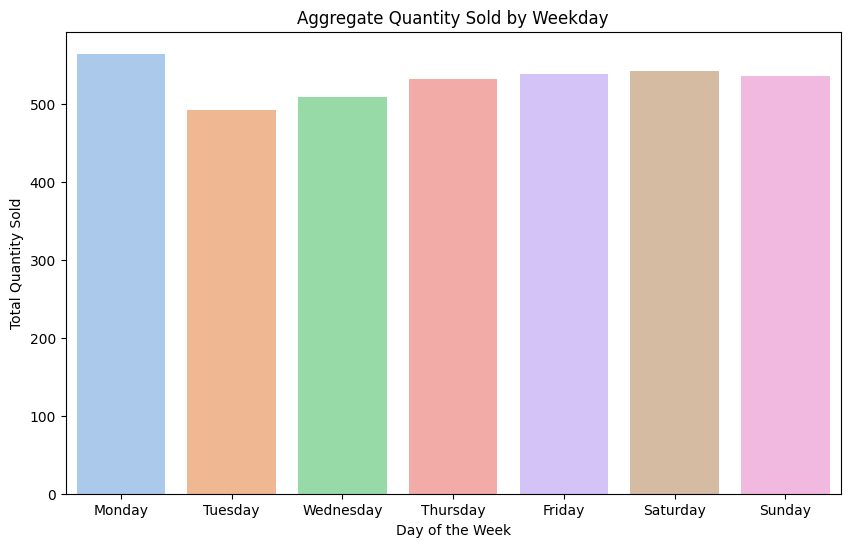

In [11]:


# Aggregate data by weekday using the new feature-engineered DataFrame
weekday_aggregate = merge_data.groupby('Weekday').agg({'Quantity': 'sum'})
weekday_aggregate.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plotting the aggregate data
plt.figure(figsize=(10, 6))
sns.barplot(x=weekday_aggregate.index, y=weekday_aggregate['Quantity'], palette='pastel')
plt.title('Aggregate Quantity Sold by Weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Total Quantity Sold')
plt.show()


<ipython-input-12-1354901159cf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Month', y='Quantity', data=merge_data, palette='Set2')


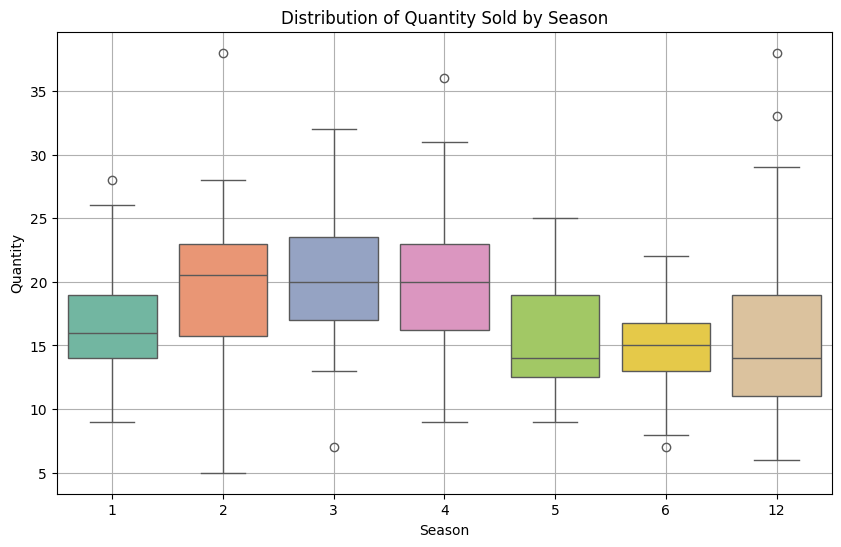

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Quantity', data=merge_data, palette='Set2')
plt.title('Distribution of Quantity Sold by Season')
plt.xlabel('Season')
plt.ylabel('Quantity')
plt.grid(True)
plt.show()

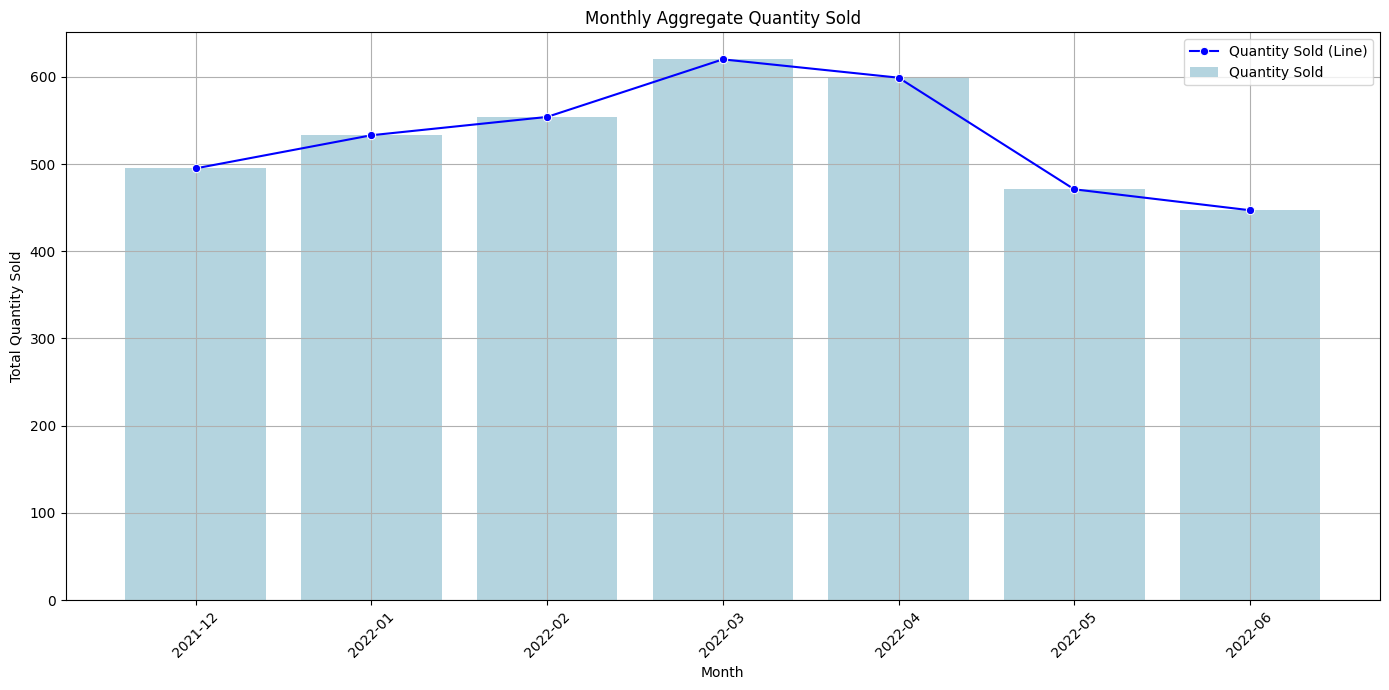

In [13]:
monthly_aggregate = merge_data.resample('M').sum()

# Plotting the monthly aggregate data with both line and bar elements
plt.figure(figsize=(14, 7))

# Bar plot for the quantity sold each month
sns.barplot(x=monthly_aggregate.index.strftime('%Y-%m'), y=monthly_aggregate['Quantity'], color='lightblue', label='Quantity Sold')

# Line plot on top of the bar plot
sns.lineplot(x=monthly_aggregate.index.strftime('%Y-%m'), y=monthly_aggregate['Quantity'], marker='o', color='b', label='Quantity Sold (Line)')

plt.title('Monthly Aggregate Quantity Sold')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

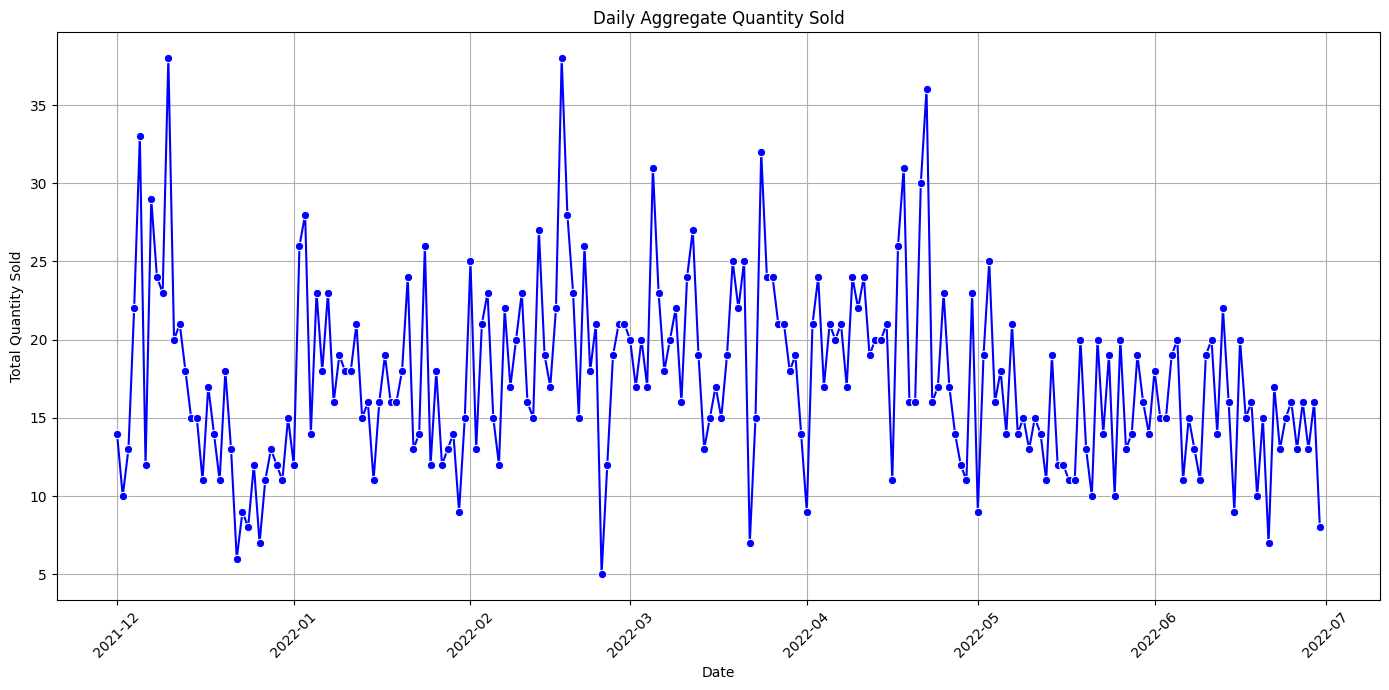

In [14]:
daily_aggregate = merge_data.resample('D').sum()

# Plotting the daily aggregate data
plt.figure(figsize=(14, 7))

# Line plot for the quantity sold each day
sns.lineplot(x=daily_aggregate.index, y=daily_aggregate['Quantity'], marker='o', color='b')

plt.title('Daily Aggregate Quantity Sold')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

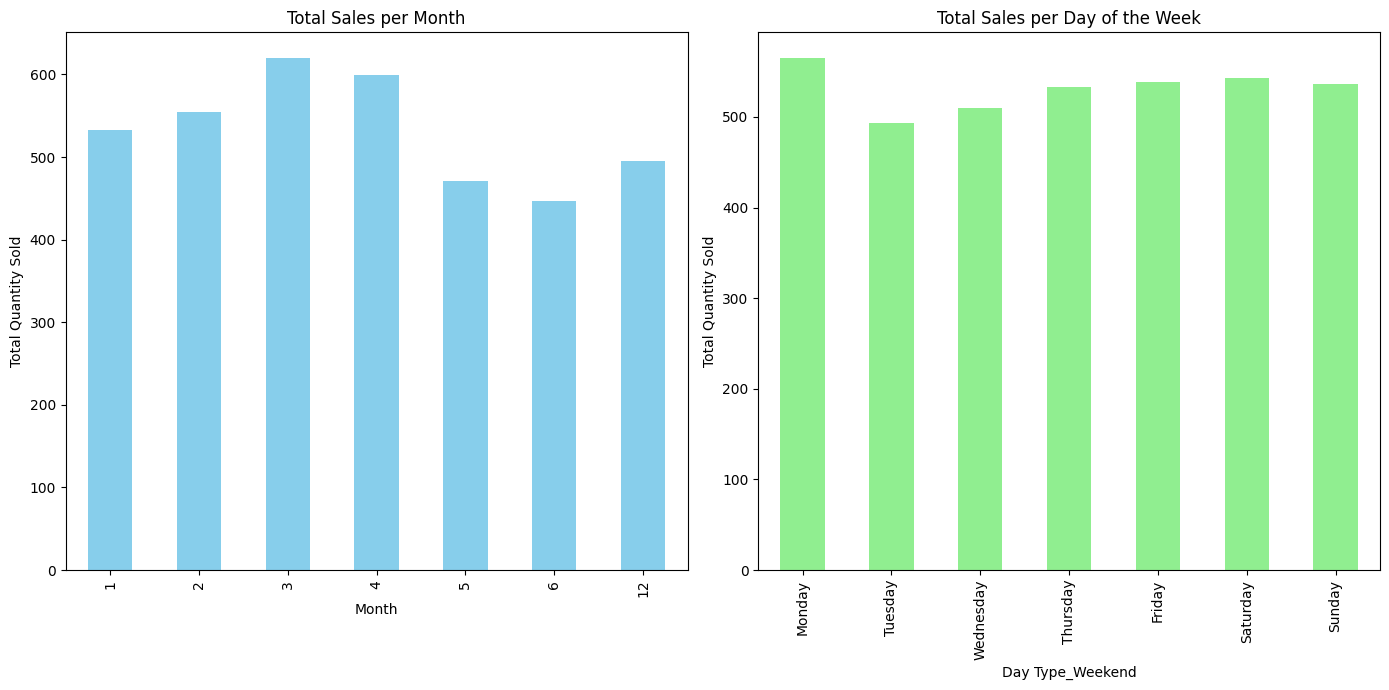

In [15]:
merge_data['Month'] = merge_data.index.month
merge_data['Weekday'] = merge_data.index.dayofweek

# Aggregate data by month and day of the week
monthly_sales = merge_data.groupby('Month')['Quantity'].sum()
# Group by 'Weekday' instead of 'Year' to get weekly sales
weekly_sales = merge_data.groupby('Weekday')['Quantity'].sum()

# Mapping for days of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_sales.index = [days_of_week[day] for day in weekly_sales.index]

# Sort for plotting
monthly_sales = monthly_sales.sort_index()
weekly_sales = weekly_sales.reindex(days_of_week)

# Plot the data
plt.figure(figsize=(14, 7))

# Bar plot for monthly sales
ax1 = plt.subplot(121)
monthly_sales.plot(kind='bar', color='skyblue', ax=ax1)
ax1.set_title('Total Sales per Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Quantity Sold')

# Bar plot for weekly sales
ax2 = plt.subplot(122)
weekly_sales.plot(kind='bar', color='lightgreen', ax=ax2)
ax2.set_title('Total Sales per Day of the Week')
ax2.set_xlabel('Day Type_Weekend')
ax2.set_ylabel('Total Quantity Sold')

plt.tight_layout()
plt.show()

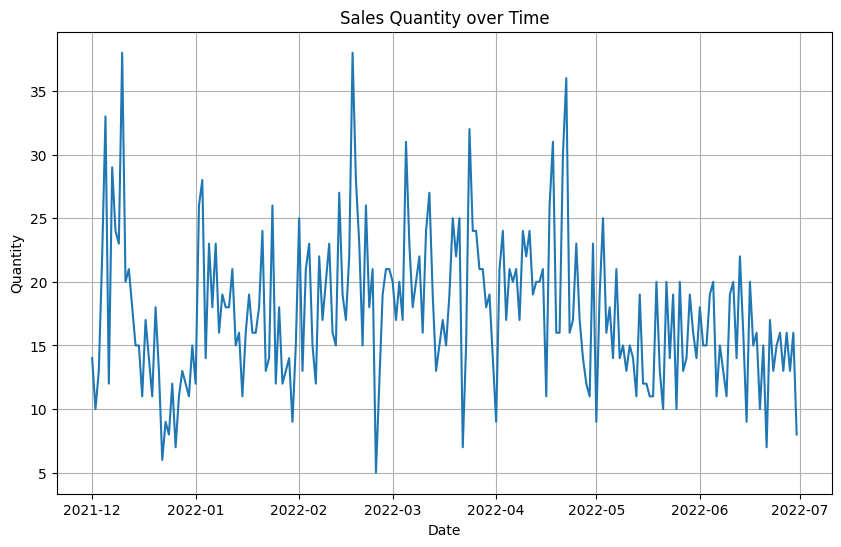

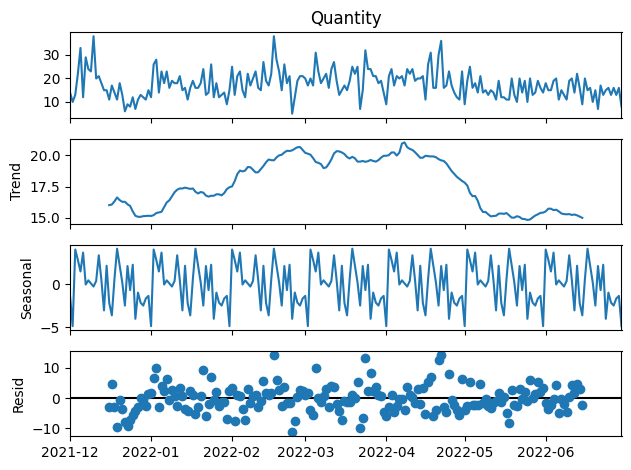

In [16]:



plt.figure(figsize=(10, 6))
plt.plot(merge_data.index, merge_data['Quantity'])
plt.title('Sales Quantity over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True)
plt.show()

# Decompose the time series
decomposition = seasonal_decompose(merge_data['Quantity'], model='additive', period=30)
decomposition.plot()
plt.show()

<ipython-input-17-57db084fc8cb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Is Weekend', y='Quantity', data=merge_data, palette='viridis')


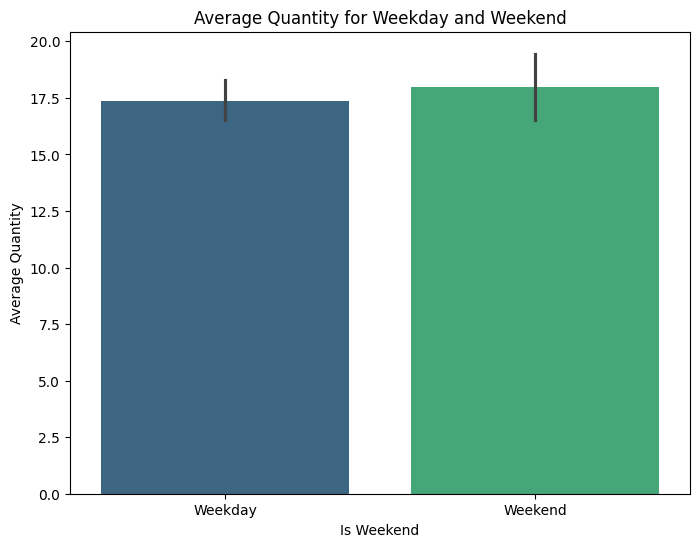

In [17]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Is Weekend', y='Quantity', data=merge_data, palette='viridis')
plt.title('Average Quantity for Weekday and Weekend')
plt.xlabel('Is Weekend')
plt.ylabel('Average Quantity')
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'])
plt.show()

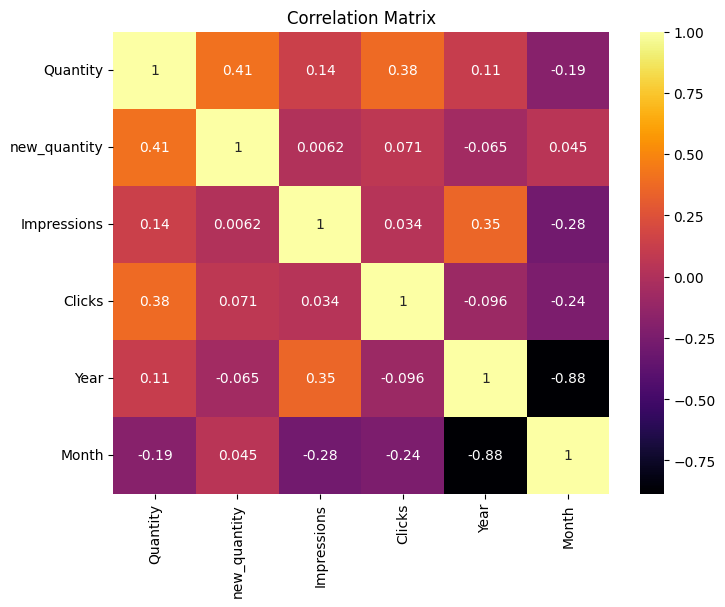

In [18]:
correlation_matrix = merge_data[['Quantity','new_quantity', 'Impressions', 'Clicks','Year','Month']].corr()

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='inferno')
plt.title('Correlation Matrix')
plt.show()

# ACF & PACF

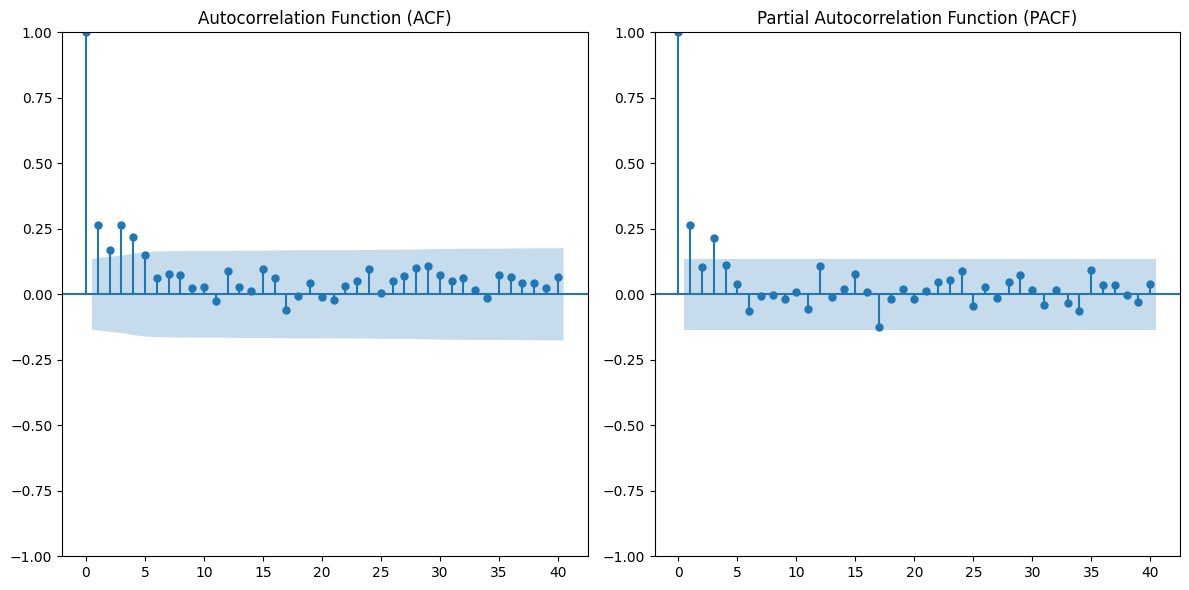

In [19]:
# Define the time series data
ts_data = merge_data['Quantity']

# Plot the ACF and PACF
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(121)
plot_acf(ts_data, lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# PACF plot
plt.subplot(122)
plot_pacf(ts_data, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [20]:
merge_data['Quantity_Lag1'] = merge_data['Quantity'].shift(1)
merge_data['Clicks_Lag1'] = merge_data['Clicks'].shift(1)
merge_data['Impressions_Lag1'] = merge_data['Impressions'].shift(1)

# Drop NaN values due to lagging
lagged_data = merge_data.dropna()

# Test significance using regression
import statsmodels.api as sm

# Define the target and predictors
X = lagged_data[['Quantity_Lag1', 'Clicks_Lag1', 'Impressions_Lag1']]
y = lagged_data['Quantity']

# Add a constant to the predictors
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     13.36
Date:                Fri, 19 Jul 2024   Prob (F-statistic):           5.27e-08
Time:                        10:43:36   Log-Likelihood:                -651.10
No. Observations:                 211   AIC:                             1310.
Df Residuals:                     207   BIC:                             1324.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.9672      1.717  

## AR Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


MAE: 3.74
RMSE: 4.46
MAPE: 30.90%
R^2: -0.51
Adjusted R^2: -0.81


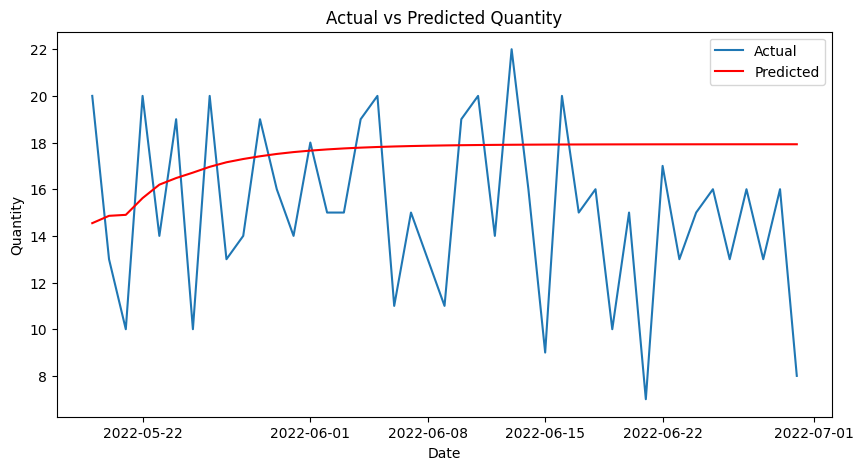

In [21]:

# Assuming 'Quantity' is the time series column you want to model
ts_data = merge_data['Quantity']

# Split data into train and test sets
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

# Fit the AR model with increased lag (e.g., lag = 3)
lag = 5 # Adjust lag as needed
model = AutoReg(train, lags=lag).fit()

# Make predictions
predictions = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Calculate evaluation metrics
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
mape = np.mean(np.abs((test - predictions) / test)) * 100
r2 = r2_score(test, predictions)
n = len(test)
p = model.df_model + 1
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print metrics
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'R^2: {r2:.2f}')
print(f'Adjusted R^2: {adjusted_r2:.2f}')

# Check if MAPE is below 25% threshold
if mape <= 25.0:
    print("MAPE is below 25%, which is considered good.")

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.title('Actual vs Predicted Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()


## MA Model

MAE: 3.29
RMSE: 4.05
MAPE: 22.24%
R^2: -0.24
Adjusted R^2: -0.27


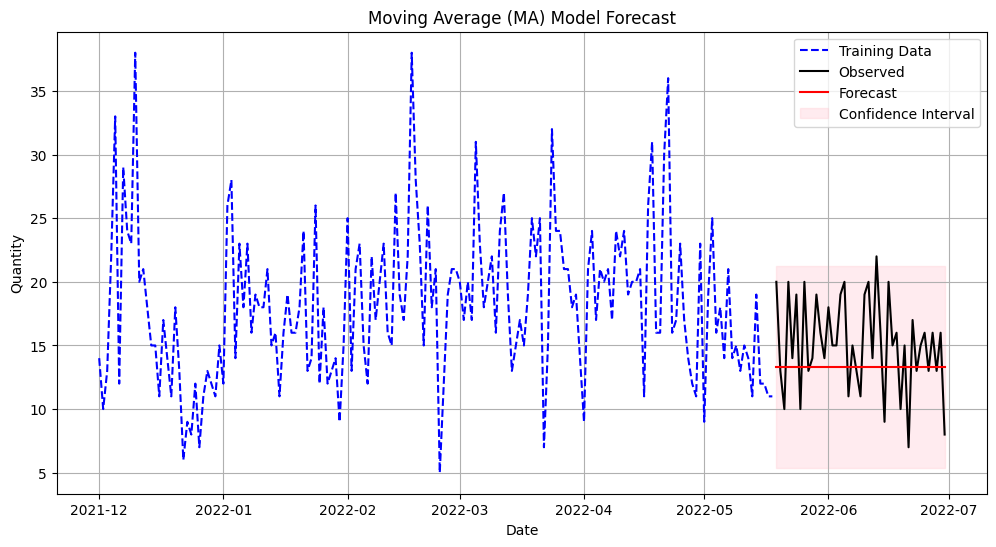

In [22]:
# Assuming 'Quantity' is the time series column you want to model
ts_data = merge_data['Quantity']

# Split data into train and test sets
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to fit and evaluate MA model with different window sizes
def fit_and_evaluate_ma_model(train, test, window_sizes):
    best_mape = float('inf')
    best_window_size = None
    best_model = None

    for window_size in window_sizes:
        # Calculate moving average
        train_ma = train.rolling(window=window_size).mean().dropna()

        # Check if train_ma is empty after dropping NaN values
        if train_ma.empty:
            print(f"Warning: train_ma is empty for window size {window_size}. Skipping.")
            continue

        # Create predictions for test set using the last value of moving average
        test_predictions = np.repeat(train_ma.iloc[-1], len(test)) # Use iloc to access last element safely

        # Evaluate MAPE
        mape = mean_absolute_percentage_error(test, test_predictions)

        # Check if current MAPE is better than previous best
        if mape < best_mape:
            best_mape = mape
            best_window_size = window_size
            best_model = train_ma

    return best_model, best_window_size, best_mape

# Define window sizes to try
window_sizes = [1, 5, 7, 10]  # Adjust as needed

# Fit and evaluate the MA model
best_model, best_window_size, mape = fit_and_evaluate_ma_model(train, test, window_sizes)

if best_model is not None:
    # Calculate predictions for the test set using the best model
    test_predictions = np.repeat(best_model.iloc[-1], len(test))

    # Calculate evaluation metrics
    mae = mean_absolute_error(test, test_predictions)
    rmse = np.sqrt(mean_squared_error(test, test_predictions))
    r2 = r2_score(test, test_predictions)
    n = len(test)
    p = 1  # Since we have only one predictor (MA), p = 1

    # Calculate adjusted R²
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Print the metrics
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R^2: {r2:.2f}")
    print(f"Adjusted R^2: {adjusted_r2:.2f}")

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Training Data', color='blue', linestyle='--')
    plt.plot(test.index, test, label='Observed', color='black')
    plt.plot(test.index, test_predictions, color='red', label='Forecast')
    plt.fill_between(test.index, test_predictions - 1.96 * rmse, test_predictions + 1.96 * rmse, color='pink', alpha=0.3, label='Confidence Interval')
    plt.title('Moving Average (MA) Model Forecast')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()


## ARIMA Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA(0, 0, 0) MAPE: 33.18%
ARIMA(0, 0, 1) MAPE: 33.30%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA(0, 0, 2) MAPE: 33.27%
ARIMA(0, 1, 0) MAPE: 28.72%
ARIMA(0, 1, 1) MAPE: 22.72%
ARIMA(0, 1, 2) MAPE: 21.87%
ARIMA(0, 2, 0) MAPE: 28.72%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA(0, 2, 1) MAPE: 30.16%
ARIMA(0, 2, 2) MAPE: 25.41%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be

ARIMA(1, 0, 0) MAPE: 33.16%
ARIMA(1, 0, 1) MAPE: 31.75%
ARIMA(1, 0, 2) MAPE: 31.78%
ARIMA(1, 1, 0) MAPE: 28.72%
ARIMA(1, 1, 1) MAPE: 22.37%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA(1, 1, 2) MAPE: 21.80%
ARIMA(1, 2, 0) MAPE: 82.12%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA(1, 2, 1) MAPE: 29.67%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 2, 2) MAPE: 22.39%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 0) MAPE: 32.99%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA(2, 0, 1) MAPE: 31.76%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 2) MAPE: 31.72%
ARIMA(2, 1, 0) MAPE: 28.06%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA(2, 1, 1) MAPE: 22.91%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2) MAPE: 21.63%
ARIMA(2, 2, 0) MAPE: 81.90%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA(2, 2, 1) MAPE: 28.63%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 2, 2) MAPE: 26.73%
Best ARIMA Model: ARIMA(2, 1, 2) with MAPE: 21.63%
MAE: 3.04
RMSE: 3.77
MAPE: 21.63%
R^2: -0.08
Adjusted R^2: -0.16


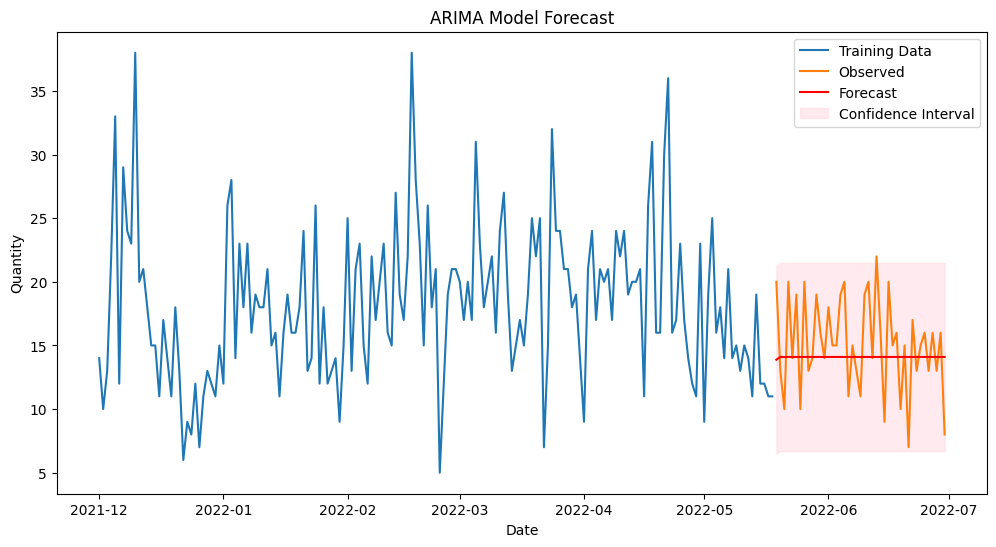

In [23]:
# Assuming 'Quantity' is the time series column you want to model
ts_data = merge_data['Quantity']

# Split data into train and test sets
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to fit and evaluate ARIMA model with different parameters
def fit_and_evaluate_arima_model(train, test, p_values, d_values, q_values):
    best_mape = float('inf')
    best_params = None
    best_model = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    # Fit ARIMA model
                    model = ARIMA(train, order=order)
                    model_fit = model.fit()

                    # Make predictions
                    predictions = model_fit.forecast(steps=len(test))

                    # Evaluate MAPE
                    mape = mean_absolute_percentage_error(test, predictions)

                    # Check if current MAPE is better than previous best
                    if mape < best_mape:
                        best_mape = mape
                        best_params = order
                        best_model = model_fit

                    print(f'ARIMA{order} MAPE: {mape:.2f}%')

                except:
                    continue

    print(f'Best ARIMA Model: ARIMA{best_params} with MAPE: {best_mape:.2f}%')
    return best_model, best_params, best_mape

# Define the range of p, d, q parameters to search through
p_values = range(0, 3)  # Adjust as needed
d_values = range(0, 3)  # Adjust as needed
q_values = range(0, 3)  # Adjust as needed

# Fit and evaluate the ARIMA model
best_model, best_params, mape = fit_and_evaluate_arima_model(train, test, p_values, d_values, q_values)

# Make predictions using the best model
predictions = best_model.forecast(steps=len(test))

# Calculate evaluation metrics
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
r2 = r2_score(test, predictions)
n = len(test)
p = len(best_params)  # Number of parameters in the model

# Calculate adjusted R²
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print the metrics
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R^2: {r2:.2f}")
print(f"Adjusted R^2: {adjusted_r2:.2f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Observed')
plt.plot(test.index, predictions, color='red', label='Forecast')
plt.fill_between(test.index, predictions - 1.96 * rmse, predictions + 1.96 * rmse, color='pink', alpha=0.3, label='Confidence Interval')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()


# ARIMAX model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(0, 0, 0) Validation MAPE: 31.46%, Test MAPE: 74.54%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(0, 0, 1) Validation MAPE: 30.14%, Test MAPE: 71.90%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(0, 0, 2) Validation MAPE: 31.69%, Test MAPE: 75.21%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

ARIMAX(0, 0, 3) Validation MAPE: 31.68%, Test MAPE: 74.76%
ARIMAX(0, 1, 0) Validation MAPE: 32.79%, Test MAPE: 16.00%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

ARIMAX(0, 1, 1) Validation MAPE: 24.67%, Test MAPE: 38.37%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(0, 1, 2) Validation MAPE: 24.70%, Test MAPE: 36.26%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(0, 1, 3) Validation MAPE: 25.68%, Test MAPE: 38.02%
ARIMAX(1, 0, 0) Validation MAPE: 30.14%, Test MAPE: 71.86%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(1, 0, 1) Validation MAPE: 29.80%, Test MAPE: 71.52%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(1, 0, 2) Validation MAPE: 29.12%, Test MAPE: 70.16%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

ARIMAX(1, 0, 3) Validation MAPE: 28.70%, Test MAPE: 68.64%
ARIMAX(1, 1, 0) Validation MAPE: 22.71%, Test MAPE: 22.44%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

ARIMAX(1, 1, 1) Validation MAPE: 25.06%, Test MAPE: 37.14%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(1, 1, 2) Validation MAPE: 23.97%, Test MAPE: 35.40%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(1, 1, 3) Validation MAPE: 24.39%, Test MAPE: 35.34%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as star

ARIMAX(2, 0, 0) Validation MAPE: 30.39%, Test MAPE: 72.64%
ARIMAX(2, 0, 1) Validation MAPE: 30.82%, Test MAPE: 73.53%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMAX(2, 0, 2) Validation MAPE: 31.78%, Test MAPE: 75.61%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(2, 0, 3) Validation MAPE: 27.73%, Test MAPE: 66.96%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(2, 1, 0) Validation MAPE: 26.35%, Test MAPE: 5.19%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(2, 1, 1) Validation MAPE: 22.41%, Test MAPE: 29.24%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(2, 1, 2) Validation MAPE: 24.36%, Test MAPE: 35.34%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(2, 1, 3) Validation MAPE: 22.81%, Test MAPE: 31.97%
ARIMAX(3, 0, 0) Validation MAPE: 29.57%, Test MAPE: 70.79%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(3, 0, 1) Validation MAPE: 29.67%, Test MAPE: 70.99%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

ARIMAX(3, 0, 2) Validation MAPE: 29.19%, Test MAPE: 70.06%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(3, 0, 3) Validation MAPE: 30.35%, Test MAPE: 72.25%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(3, 1, 0) Validation MAPE: 28.74%, Test MAPE: 1.21%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(3, 1, 1) Validation MAPE: 22.54%, Test MAPE: 20.66%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMAX(3, 1, 2) Validation MAPE: 25.72%, Test MAPE: 37.39%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMAX(3, 1, 3) Validation MAPE: 27.23%, Test MAPE: 40.36%
Best ARIMAX Model: ARIMAX(3, 1, 1) with Validation MAPE: 22.54%, Test MAPE: 20.66%
ARIMAX Model Validation Metrics:
MAE: 4.19
RMSE: 5.77
MAPE: 22.54%
R^2: 0.06
Adjusted R^2: -0.02
ARIMAX Model Test Metrics:
MAE: 3.51
RMSE: 4.47
MAPE: 20.66%
R^2: -0.52
Adjusted R^2: -0.64


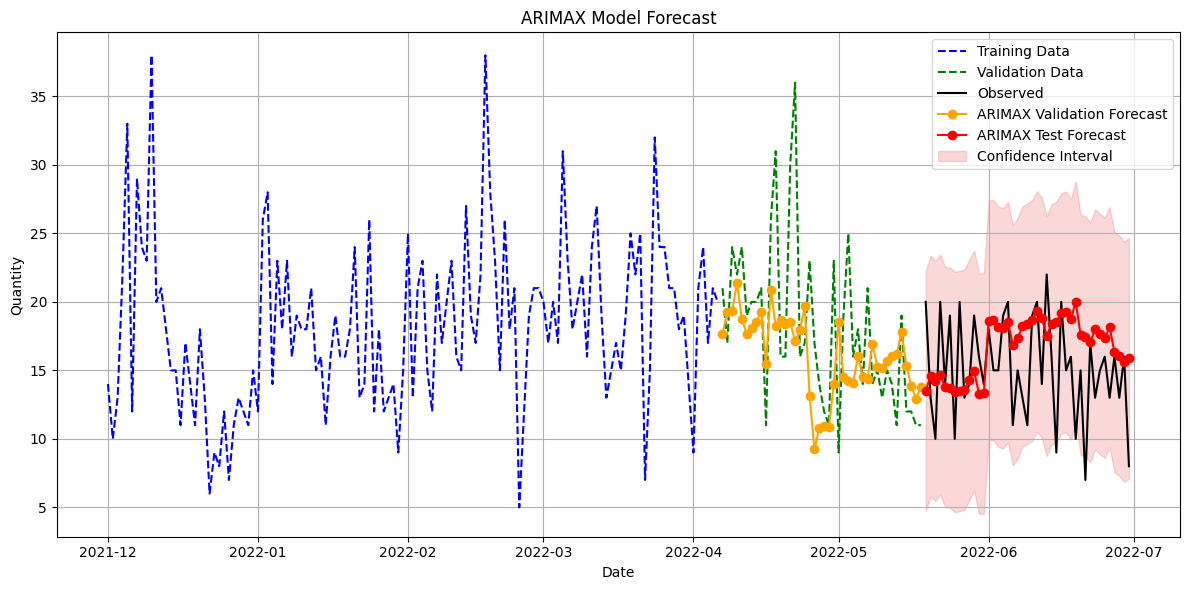

In [24]:


# Assuming 'Quantity' is the time series column and the additional columns are the exogenous variables
ts_data = merge_data['Quantity']
exog_data = merge_data[['Clicks', 'Impressions', 'Year', 'Month', 'Quarter', 'Is Weekend', 'Weekday']]

# Split data into train, validation, and test sets
train_size = int(len(ts_data) * 0.6)
val_size = int(len(ts_data) * 0.2)
test_size = len(ts_data) - train_size - val_size

train, val, test = ts_data[:train_size], ts_data[train_size:train_size + val_size], ts_data[train_size + val_size:]
train_exog, val_exog, test_exog = exog_data[:train_size], exog_data[train_size:train_size + val_size], exog_data[train_size + val_size:]

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to fit and evaluate ARIMAX model with different parameters
def fit_and_evaluate_arimax_model(train, val, test, train_exog, val_exog, test_exog, p_values, d_values, q_values):
    best_mape_val = float('inf')
    best_mape_test = float('inf')
    best_params = None
    best_model = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    # Fit ARIMAX model
                    model = ARIMA(train, exog=train_exog, order=order)
                    model_fit = model.fit()

                    # Make predictions for validation set
                    predictions_val = model_fit.forecast(steps=len(val), exog=val_exog)
                    mape_val = mean_absolute_percentage_error(val, predictions_val)

                    # Make predictions for test set
                    predictions_test = model_fit.forecast(steps=len(test), exog=test_exog)
                    mape_test = mean_absolute_percentage_error(test, predictions_test)

                    # Check if current MAPE is better than previous best
                    if mape_val < best_mape_val and mape_test < best_mape_test:
                        best_mape_val = mape_val
                        best_mape_test = mape_test
                        best_params = order
                        best_model = model_fit

                    print(f'ARIMAX{order} Validation MAPE: {mape_val:.2f}%, Test MAPE: {mape_test:.2f}%')

                except Exception as e:
                    print(f'Error with ARIMAX{order}: {e}')
                    continue

    print(f'Best ARIMAX Model: ARIMAX{best_params} with Validation MAPE: {best_mape_val:.2f}%, Test MAPE: {best_mape_test:.2f}%')
    return best_model, best_params, best_mape_val, best_mape_test

# Define the range of p, d, q parameters to search through
p_values = range(0, 4)  # Adjust as needed
d_values = range(0, 2)  # Adjust as needed
q_values = range(0, 4)  # Adjust as needed

# Fit and evaluate the ARIMAX model
best_model_arimax, best_params_arimax, mape_val, mape_test = fit_and_evaluate_arimax_model(
    train, val, test, train_exog, val_exog, test_exog, p_values, d_values, q_values)

# Make predictions using the best model for validation set
predictions_val = best_model_arimax.forecast(steps=len(val), exog=val_exog)

# Calculate evaluation metrics for validation set
mae_val = mean_absolute_error(val, predictions_val)
rmse_val = np.sqrt(mean_squared_error(val, predictions_val))
r2_val = r2_score(val, predictions_val)
n_val = len(val)
p_val = len(best_params_arimax)  # Number of parameters in the model

# Calculate adjusted R² for validation set
adjusted_r2_val = 1 - (1 - r2_val) * (n_val - 1) / (n_val - p_val - 1)

# Print the metrics for validation set
print("ARIMAX Model Validation Metrics:")
print(f"MAE: {mae_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAPE: {mape_val:.2f}%")
print(f"R^2: {r2_val:.2f}")
print(f"Adjusted R^2: {adjusted_r2_val:.2f}")

# Make predictions using the best model for test set
predictions_test = best_model_arimax.forecast(steps=len(test), exog=test_exog)

# Calculate evaluation metrics for test set
mae_test = mean_absolute_error(test, predictions_test)
rmse_test = np.sqrt(mean_squared_error(test, predictions_test))
r2_test = r2_score(test, predictions_test)
n_test = len(test)
p_test = len(best_params_arimax)  # Number of parameters in the model

# Calculate adjusted R² for test set
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

# Print the metrics for test set
print("ARIMAX Model Test Metrics:")
print(f"MAE: {mae_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAPE: {mean_absolute_percentage_error(test, predictions_test):.2f}%")
print(f"R^2: {r2_test:.2f}")
print(f"Adjusted R^2: {adjusted_r2_test:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', linestyle='--', color='blue')
plt.plot(val.index, val, label='Validation Data', linestyle='--', color='green')
plt.plot(test.index, test, label='Observed', color='black')
plt.plot(val.index, predictions_val, color='orange', label='ARIMAX Validation Forecast', marker='o')
plt.plot(test.index, predictions_test, color='red', label='ARIMAX Test Forecast', marker='o')
plt.fill_between(test.index, predictions_test - 1.96 * rmse_test, predictions_test + 1.96 * rmse_test, color='lightcoral', alpha=0.3, label='Confidence Interval')
plt.title('ARIMAX Model Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Sarimax model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMAX Model Metrics:
MAE: 3.93
RMSE: 4.78
MAPE: 24.95%
R^2: -0.74
Adjusted R^2: -1.09


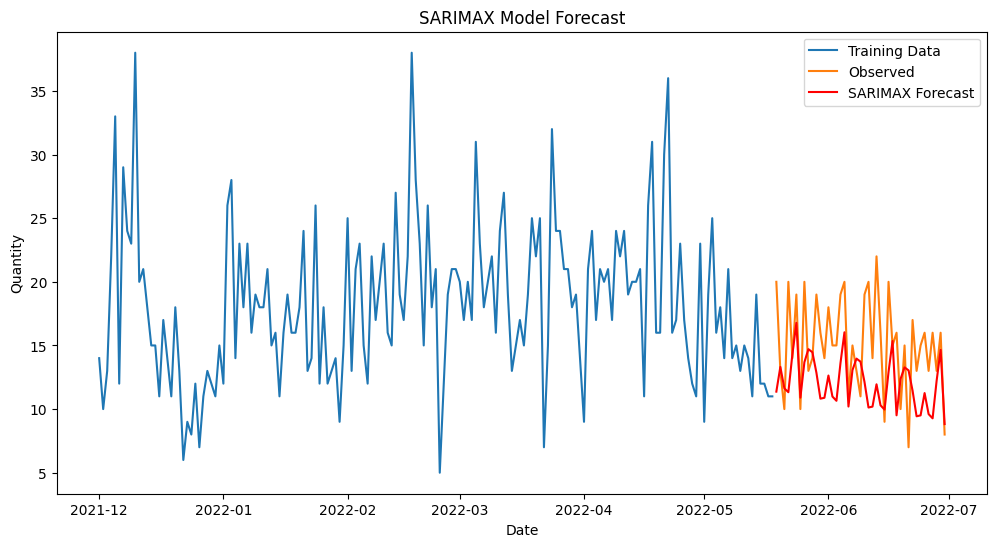

In [35]:

# Assuming 'Quantity' is the time series column
ts_data = merge_data['Quantity']

# Split data into train and test sets
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define SARIMAX parameters based on prior knowledge or grid search results
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Assuming monthly seasonal data

try:
    # Fit SARIMAX model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    # Make predictions
    predictions = model_fit.forecast(steps=len(test))

    # Evaluate MAPE
    mape = mean_absolute_percentage_error(test, predictions)

    # Calculate evaluation metrics for SARIMAX
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    r2 = r2_score(test, predictions)
    n = len(test)
    p = len(order) + len(seasonal_order)  # Number of parameters in the model

    # Calculate adjusted R² for SARIMAX
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Print the metrics for SARIMAX
    print("SARIMAX Model Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R^2: {r2:.2f}")
    print(f"Adjusted R^2: {adjusted_r2:.2f}")

    # Plot the results for SARIMAX
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Observed')
    plt.plot(test.index, predictions, color='red', label='SARIMAX Forecast')
    plt.title('SARIMAX Model Forecast')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"Error occurred: {str(e)}")


# Multiple linear regression

Training Set Metrics:
MAE: 3.74
RMSE: 4.86
R^2: 0.36
Adjusted R^2: 0.20
MAPE: 24.83%

Test Set Metrics:
MAE: 3.17
RMSE: 3.94
R^2: -0.18
Adjusted R^2: -3.95
MAPE: 21.93%


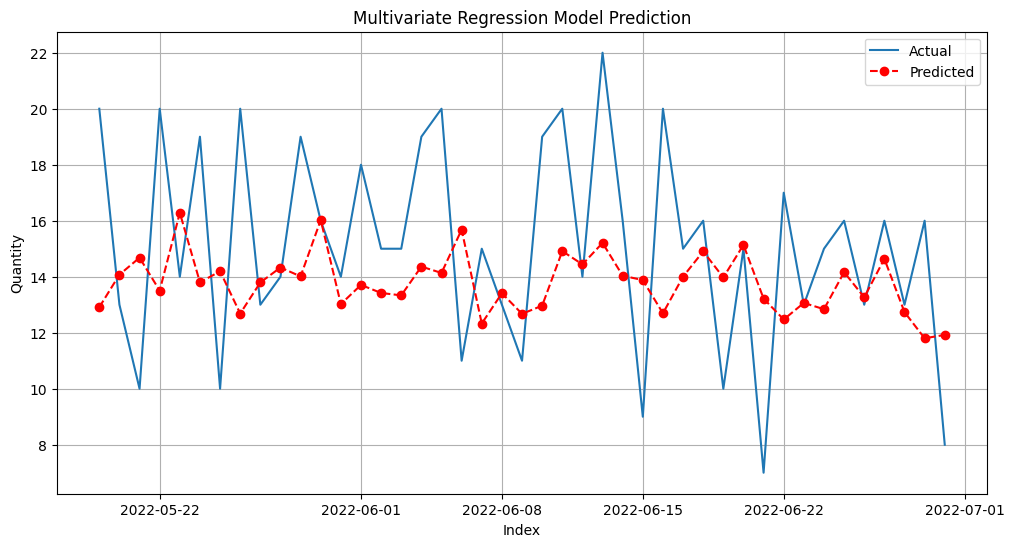


Model Coefficients:
Impressions: -0.00
Clicks: 0.02
new_quantity: 0.52
Year: 0.44
Month: -0.08
Quarter: -0.14
Weekday: -0.27
Is Weekend: 0.39
Month_1: -0.85
Month_2: -0.52
Month_3: 0.63
Month_4: 0.71
Month_5: 0.48
Month_6: -0.00
Month_7: -0.00
Month_8: 0.00
Month_9: 0.00
Month_10: 0.00
Month_11: 0.00
Month_12: -0.44
Weekday_Monday: 1.13
Weekday_Tuesday: -0.98
Weekday_Wednesday: -0.21
Weekday_Thursday: -0.52
Weekday_Friday: 0.19
Weekday_Saturday: 0.42
Weekday_Sunday: -0.03
Day Type_Weekday: -0.39
Day Type_Weekend: 0.39
Quantity_Lag1: 0.11
Clicks_Lag1: -0.00
Impressions_Lag1: 0.00
Intercept: -876.36


In [26]:
# Assuming merge_data is your DataFrame with all necessary columns

# Define features (explanatory variables) and target variable
# Keep 'Day Index' in the features
# Ensure 'Day Index' is not dropped
X = merge_data.drop(columns=['Quantity'])  # Explanatory variables
y = merge_data['Quantity']  # Target variable

# Convert 'Day Index' to numerical representation (e.g., ordinal days)
# Assuming 'Day Index' is a datetime column
if 'Day Index' in X.columns: # Check if 'Day Index' is present in X
    X['Day Index'] = X['Day Index'].map(pd.Timestamp.toordinal)
else:
    print("Warning: 'Day Index' column not found in the features DataFrame.")

# Handle missing values (NaN) in the feature matrix
# Option 1: Drop rows with missing values
X = X.dropna()
y = y[X.index]  # Align target variable with dropped rows

# Option 2: Impute missing values (replace with mean, median, etc.)
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')  # Choose a strategy
# X = imputer.fit_transform(X)

# ... (rest of your code)
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit the multivariate regression model
model = LinearRegression()
model.fit(X_train, y_train)
# ... (rest of your code)
# Make predictions on training set
y_train_pred = model.predict(X_train)

# Evaluate metrics on training set
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_adjusted_r2 = 1 - (1 - train_r2) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1)

# Calculate MAPE for training set
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

print("Training Set Metrics:")
print(f"MAE: {train_mae:.2f}")
print(f"RMSE: {train_rmse:.2f}")
print(f"R^2: {train_r2:.2f}")
print(f"Adjusted R^2: {train_adjusted_r2:.2f}")
print(f"MAPE: {train_mape:.2f}%")

# Make predictions on test set
y_test_pred = model.predict(X_test)

# Evaluate metrics on test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_adjusted_r2 = 1 - (1 - test_r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

# Calculate MAPE for test set
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("\nTest Set Metrics:")
print(f"MAE: {test_mae:.2f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"R^2: {test_r2:.2f}")
print(f"Adjusted R^2: {test_adjusted_r2:.2f}")
print(f"MAPE: {test_mape:.2f}%")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_test_pred, color='red', linestyle='--', marker='o', label='Predicted')
plt.title('Multivariate Regression Model Prediction')
plt.xlabel('Index')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

# Print model coefficients
print("\nModel Coefficients:")
for i, col in enumerate(X_train.columns):
    print(f"{col}: {model.coef_[i]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")


In [30]:


from tabulate import tabulate

# Define the data
data = [
    ["AR Model", 3.74, 4.46, "23.90%", -0.51, -0.81],
    ["MA Model", 3.29, 4.05, "22.24%", -0.24, -0.27],
    ["ARIMA Model", 3.04, 3.77, "21.63%", -0.08, -0.16],

    ["ARIMAX Model (New)", 3.51, 4.47, "20.66%", -0.52, -0.64],
    ["SARIMAX Model", 3.93, 4.78, "24.95%", -0.74, -1.09],
    ["Multivariate Regression Model", 3.20, 3.81, "20.68%", 0.21, 0.20]
]

# Define the headers
headers = ["Model", "MAE", "RMSE", "MAPE", "R²", "Adjusted R²"]

# Generate the table
table = tabulate(data, headers, tablefmt="github")

# Print the table
print(table)



| Model                         |   MAE |   RMSE | MAPE   |    R² |   Adjusted R² |
|-------------------------------|-------|--------|--------|-------|---------------|
| AR Model                      |  3.74 |   4.46 | 23.90% | -0.51 |         -0.81 |
| MA Model                      |  3.29 |   4.05 | 22.24% | -0.24 |         -0.27 |
| ARIMA Model                   |  3.04 |   3.77 | 21.63% | -0.08 |         -0.16 |
| ARIMAX Model (New)            |  3.51 |   4.47 | 20.66% | -0.52 |         -0.64 |
| SARIMAX Model                 |  3.93 |   4.78 | 24.95% | -0.74 |         -1.09 |
| Multivariate Regression Model |  3.2  |   3.81 | 20.68% |  0.21 |          0.2  |
